In [1]:
from qiskit import IBMQ, QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter
from qiskit.compiler import transpile
from qiskit.visualization import plot_circuit_layout, plot_histogram, plot_circuit_layout
from qiskit.test.mock import FakeBelem
from qiskit.tools.monitor import job_monitor

import networkx as nx
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

provider = IBMQ.load_account()

In [2]:
'''
ECE 520 - Final Project 
Author: Grant Eberle

Implementation of QAOA used to solve the Maximum Cut problem on graph representations of IBM's Quantum Computers 

1. Simulation AND experimental results of QAOA on graph representation of ibmq_belem 
2. Simulation AND experimental results of QAOA on graph that does not match ibmq_belem layout

*** Code Referenced and Adapted From: https://qiskit.org/textbook/ch-applications/qaoa.html ***

'''

"\nECE 520 - Final Project \nAuthor: Grant Eberle\n\nImplementation of QAOA alorithm used to solve the Maximum Cut problem on graph representations of IBM's Quantum Computers \n\n1. Simulation AND experimental results of QAOA on graph representation of ibmq_belem \n2. Simulation AND experimental results of QAOA on graph that does not match ibmq_belem layout\n\n*** Code Referenced and Adapted From: https://qiskit.org/textbook/ch-applications/qaoa.html ***\n\n"

In [3]:
### FUNCTIONS USED TO RUN QAOA ###

In [4]:
# Function returns number of edges shared between the two partitions of the graph
def maxcut_obj(x, G):
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= 1
            
    return obj

In [5]:
# Computes expectation value based on measurement results
def compute_expectation(counts, G):
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring, G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count

In [6]:
# Creates a parametrized QAOA circuit
def create_qaoa_circ(G, theta):
    nqubits = len(G.nodes())
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        # problem unitary
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep], pair[0], pair[1])

        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
            
    qc.measure_all()
        
    return qc

In [7]:
# Runs a parametrized circit 
def get_expectation(G, p, shots=512):
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(G, theta)
        counts = backend.run(qc, seed_simulator=512, 
                             nshots=512).result().get_counts()
        
        return compute_expectation(counts, G)
    
    return execute_circ

In [8]:
### MIXING UNITARY ###
def mix_unitary(graph, nqubits):
    adjacency = nx.adjacency_matrix(G_r4T).todense()
    beta = Parameter("$\\alpha$")
    qc_mix = QuantumCircuit(nqubits)
    for i in range(0, nqubits):
        qc_mix.rx(2 * beta, i)
    return qc_mix

In [9]:
### PROBLEM UNITARY ###
def prob_unitary(graph, nqubits):
    gamma = Parameter("$\\beta$")
    qc_p = QuantumCircuit(nqubits)
    for pair in list(G_r4T.edges()):  # pairs of nodes
        qc_p.rzz(2 * gamma, pair[0], pair[1])
        qc_p.barrier()
    return qc_p

In [10]:
### INITIAL STATE ###
def init_state(nqubits):
    qc_0 = QuantumCircuit(nqubits)
    for i in range(0, nqubits):
        qc_0.h(i)
    return qc_0

In [11]:
### EXPECTATION VALUE AND CLASSICAL OPTIMIZATION ALGORITHM ###
def exp_value(graph, method):
    expectation = get_expectation(graph, p=1)
    return minimize(expectation, 
                      [1.0, 1.0], 
                      method=method)

In [12]:
### DEFINITION OF BACKENDS FOR EXPERIMENTS ###
device_name = 'ibmq_belem'
fake_device = FakeBelem()
simulator = Aer.get_backend('aer_simulator')
sim_device = simulator.from_backend(fake_device)
device = provider.get_backend(device_name)
nqubits = 5

### FUNCTION FOR RUNNING EXPERIMENTS ###
# Args: experiment parameters (backend, number of shots, graph representation of backend, result)
# Returns: counts from experiment
def run_experiment(backend, shots, graph, res):
    backend.shots = shots
    qc_res = create_qaoa_circ(graph, res.x)
    qc_trans = transpile(qc_res, basis_gates = ['id', 'rz', 'sx', 'x', 'cx', 'reset'], optimization_level = 3)
    job = backend.run(qc_trans, seed_simulator=10)
    job_monitor(job)
    counts = job.result().get_counts()
    return counts

In [13]:
"""

1. Simulation AND experimental results of QAOA on graph representation of ibmq_belem 

"""

'\n\n1. Simulation AND experimental results of QAOA on graph representation of ibmq_belem \n\n'

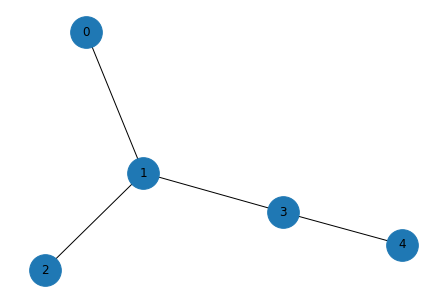

In [14]:
### CREATION OF GRAPH ###
# Graph representing IBM Falcon r4T processor layout
G_r4T = nx.Graph()
G_r4T.add_nodes_from([0, 1, 2, 3, 4])
G_r4T.add_edges_from([(0, 1), (1, 2), (1, 3), (3, 4)])
nx.draw(G_r4T, with_labels = True, alpha = 1, node_size = 1000)

In [15]:
### QAOA CIRCUIT ###
qc1_qaoa = QuantumCircuit(nqubits)

qc1_0 = init_state(nqubits)
qc1_mix = mix_unitary(G_r4T, nqubits)
qc1_prob = prob_unitary(G_r4T, nqubits)

qc1_qaoa.append(qc1_0, [i for i in range(0, nqubits)])
qc1_qaoa.append(qc1_mix, [i for i in range(0, nqubits)])
qc1_qaoa.append(qc1_prob, [i for i in range(0, nqubits)])

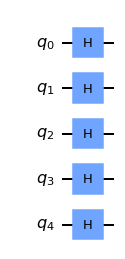

In [16]:
qc1_0.draw('mpl')

/home/geberle/anaconda3/envs/QLAB/lib/python3.8/site-packages/sympy/core/expr.py:2451: SymPyDeprecationWarning: 

expr_free_symbols method has been deprecated since SymPy 1.9. See
https://github.com/sympy/sympy/issues/21494 for more info.

  SymPyDeprecationWarning(feature="expr_free_symbols method",


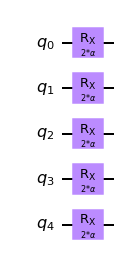

In [17]:
qc1_mix.draw('mpl')

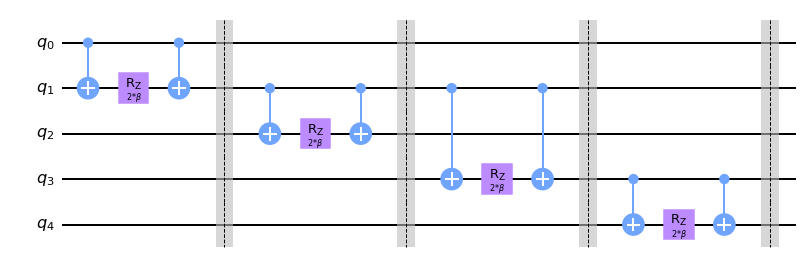

In [18]:
qc1_prob.decompose().draw('mpl')

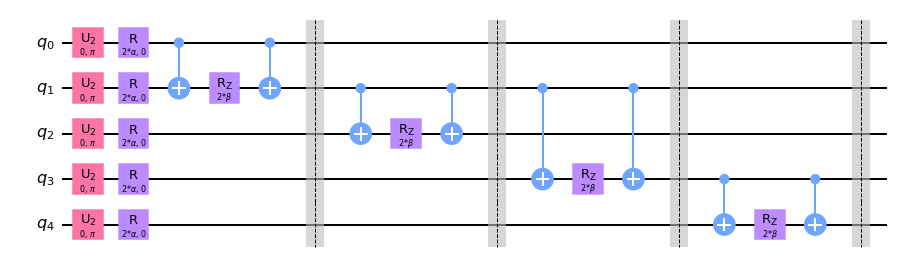

In [19]:
qc1_qaoa.decompose().decompose().draw('mpl')

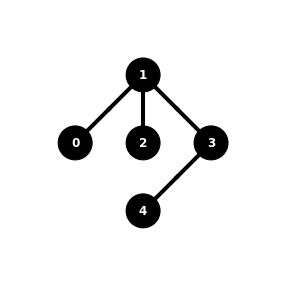

In [39]:
### CIRCUIT LAYOUT ###
qc1_qaoa_trans = transpile(qc1_qaoa, backend=device, optimization_level=3)
plot_circuit_layout(qc1_qaoa_trans, device)

In [20]:
### EXPECTATION VALUE AND CLASSICAL OPTIMIZATION ALGORITHM ###
res = exp_value(G_r4T, 'COBYLA')
print(res)

     fun: -2.7109375
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 29
  status: 1
 success: True
       x: array([1.22992406, 0.41187807])


Job Status: job has successfully run


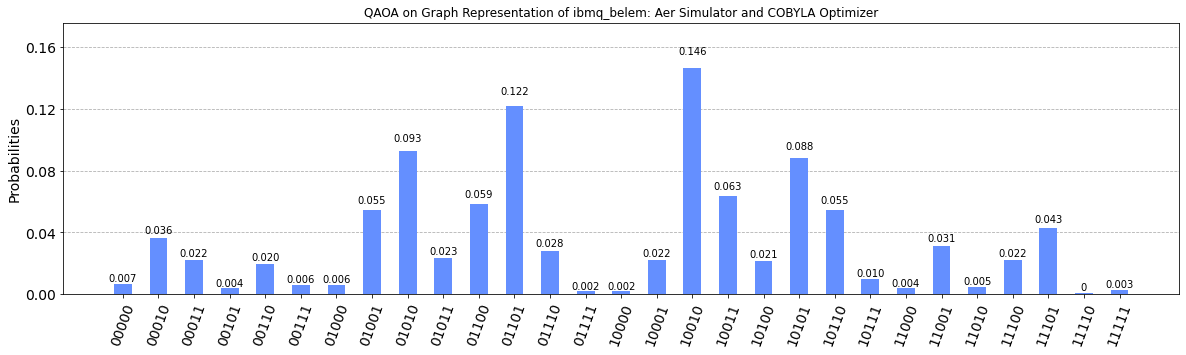

In [21]:
### SIMULATOR RESULTS ###
counts = run_experiment(simulator, 8192, G_r4T, res)
plot_histogram(counts, (20,5), title = "QAOA on Graph Representation of ibmq_belem: Aer Simulator and COBYLA Optimizer")

Job Status: job has successfully run


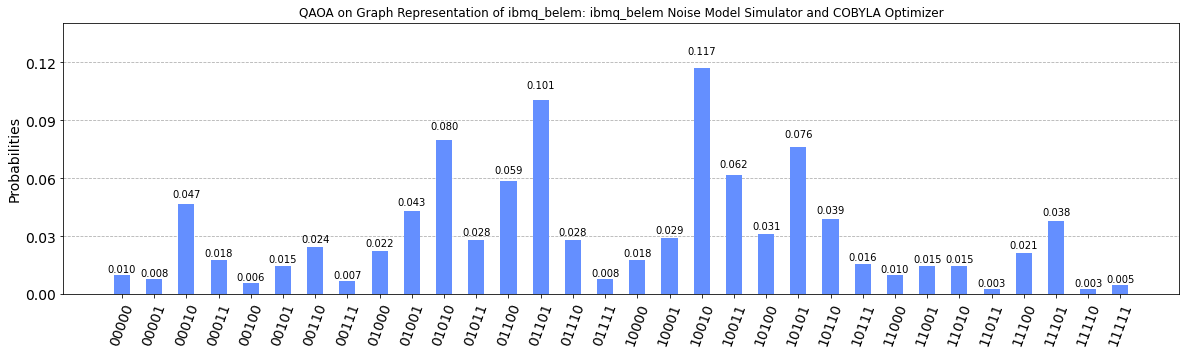

In [22]:
### IBMQ_BELEM NOISE MODEL SIMULATION RESULTS ###
counts = run_experiment(sim_device, 8192, G_r4T, res)
plot_histogram(counts, (20,5), title = "QAOA on Graph Representation of ibmq_belem: ibmq_belem Noise Model Simulator and COBYLA Optimizer")

/tmp/ipykernel_448/1817631648.py:16: UserWarning: seed_simulator is not a recognized runtime option and may be ignored by the backend.
  job = backend.run(qc_trans, seed_simulator=10)


Job Status: job has successfully run


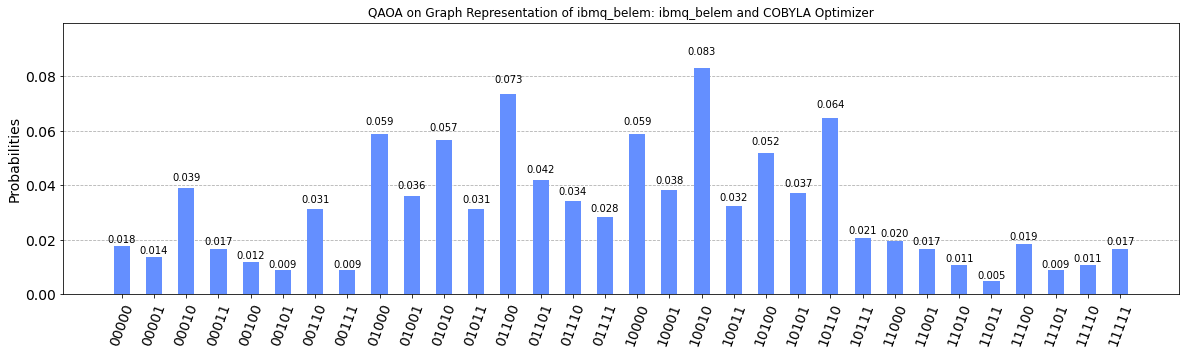

In [23]:
### IBMQ_BELEM RESULTS ###
counts = run_experiment(device, 8192, G_r4T, res)
plot_histogram(counts, (20,5), title = "QAOA on Graph Representation of ibmq_belem: ibmq_belem and COBYLA Optimizer")

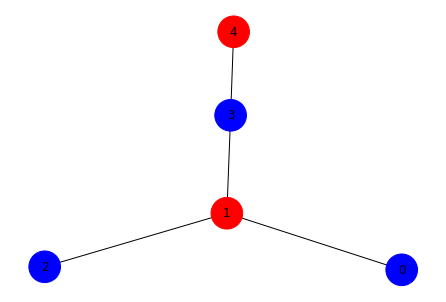

In [24]:
### RECOLORED GRAPH ACCORDING TO EXPERIMENTAL RESULTS ###
color_map = []
for bit in counts.most_frequent()[::-1]:
    if bit == '1':
        color_map.append('red')
    else:
        color_map.append('blue')
        
nx.draw(G_r4T, with_labels = True, node_color = color_map, alpha = 1, node_size = 1000)

In [25]:
"""

2. Simulation AND experimental results of QAOA on graph that does not match ibmq_belem layout

"""

'\n\n2. Simulation AND experimental results of QAOA on graph that does not match ibmq_belem layout\n\n'

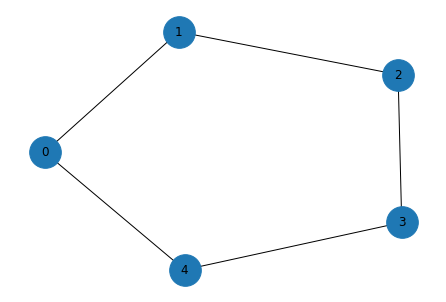

In [26]:
### CREATION OF GRAPH THAT DOES NOT MATCH r4T layout ###
# Graph created in the shape of a pentagon
G_pent = nx.Graph()
G_pent.add_nodes_from([0, 1, 2, 3, 4])
G_pent.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 4), (4, 0)])
nx.draw(G_pent, with_labels = True, alpha = 1, node_size = 1000)

In [27]:
### QAOA CIRCUIT ###
qc2_qaoa = QuantumCircuit(nqubits)

qc2_0 = init_state(nqubits)
qc2_mix = mix_unitary(G_pent, nqubits)
qc2_prob = prob_unitary(G_pent, nqubits)

qc2_qaoa.append(qc2_0, [i for i in range(0, nqubits)])
qc2_qaoa.append(qc2_mix, [i for i in range(0, nqubits)])
qc2_qaoa.append(qc2_prob, [i for i in range(0, nqubits)])

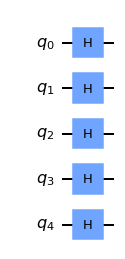

In [28]:
qc2_0.draw('mpl')

/home/geberle/anaconda3/envs/QLAB/lib/python3.8/site-packages/sympy/core/expr.py:2451: SymPyDeprecationWarning: 

expr_free_symbols method has been deprecated since SymPy 1.9. See
https://github.com/sympy/sympy/issues/21494 for more info.

  SymPyDeprecationWarning(feature="expr_free_symbols method",


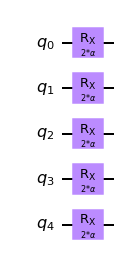

In [29]:
qc2_mix.draw('mpl')

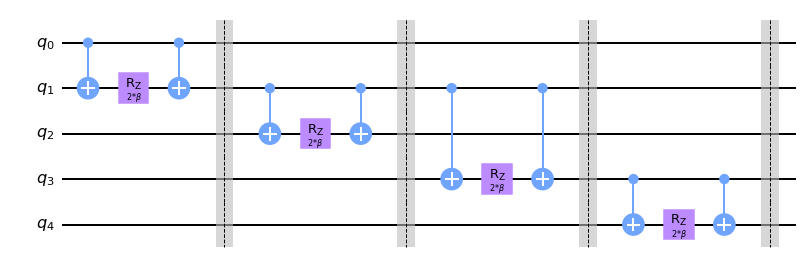

In [30]:
qc2_prob.decompose().draw('mpl')

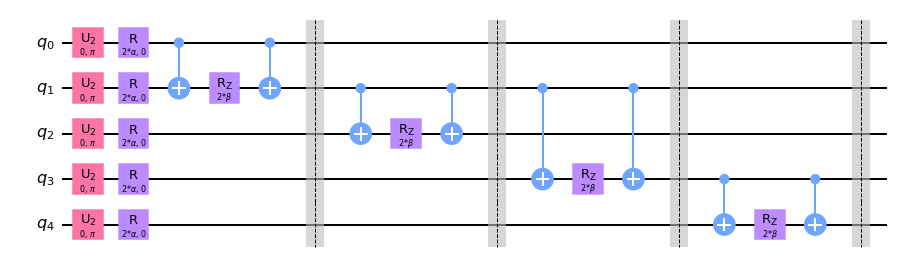

In [31]:
qc2_qaoa.decompose().decompose().draw('mpl')

In [32]:
### EXPECTATION VALUE AND CLASSICAL OPTIMIZATION ALGORITHM ###
res = exp_value(G_pent, 'COBYLA')
print(res)

     fun: -3.76171875
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 27
  status: 1
 success: True
       x: array([1.93552593, 1.20318296])


Job Status: job has successfully run


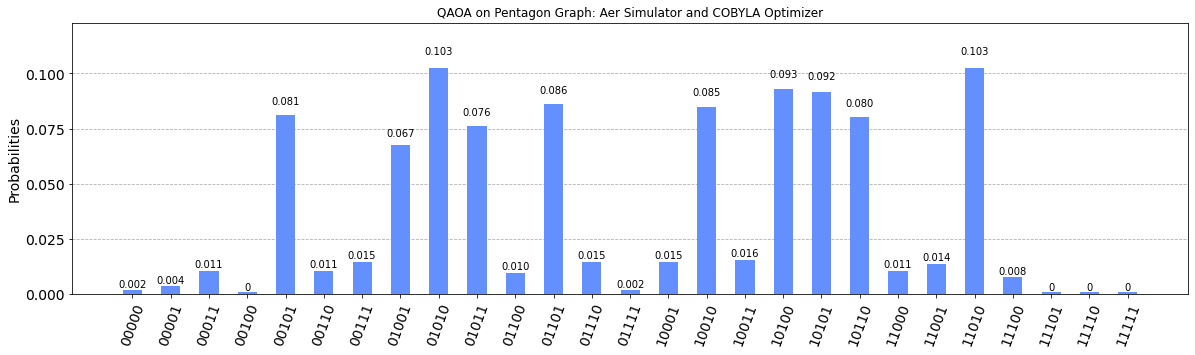

In [33]:
### SIMULATOR RESULTS ###
counts = run_experiment(simulator, 8192, G_pent, res)
plot_histogram(counts, (20,5), title = "QAOA on Pentagon Graph: Aer Simulator and COBYLA Optimizer")

Job Status: job has successfully run


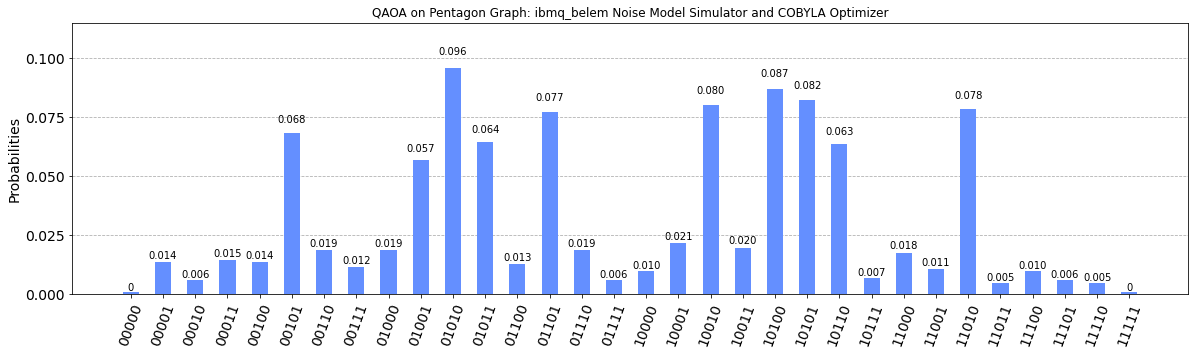

In [34]:
### IBMQ_BELEM NOISE MODEL SIMULATION RESULTS ###
counts = run_experiment(sim_device, 8192, G_pent, res)
plot_histogram(counts, (20,5), title = "QAOA on Pentagon Graph: ibmq_belem Noise Model Simulator and COBYLA Optimizer")

In [35]:
### IBMQ_BELEM RESULTS ###
# counts = run_experiment(device, 8192, G_pent, res)
# plot_histogram(counts, (20,5), title = "QAOA on Pentagon Graph: ibmq_belem and COBYLA Optimizer")

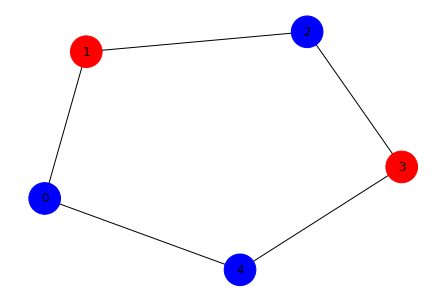

In [36]:
### RECOLORED GRAPH ACCORDING TO EXPERIMENTAL RESULTS ###
color_map = []
for bit in counts.most_frequent()[::-1]:
    if bit == '1':
        color_map.append('red')
    else:
        color_map.append('blue')
        
nx.draw(G_pent, with_labels = True, node_color = color_map, alpha = 1, node_size = 1000)